In [429]:
import mne, os
from signal_processing.pre_process import *
from basic.arrange_data import read_files
import numpy as np
from cmath import nan
import matplotlib.pyplot as plt
import pandas as pd

mne.set_log_level('error')

**Set the folder of EEG files**

Run the cell to be prompted with an input box for choosing the folder containing the EEG files of interest.

*NB! The path has to be in 'Data\Raw\' folder relative to this notebook.*

In [438]:
exp_folder = r"" # in case you want to just type the dir here
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')

raw_folder = r"Data/Raw/AO_test/"
clean_folder = r"Data/Clean/AO_test"
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)

file_dirs, subject_names = read_files(dir_inprogress,".bdf")

Files in folder: 3


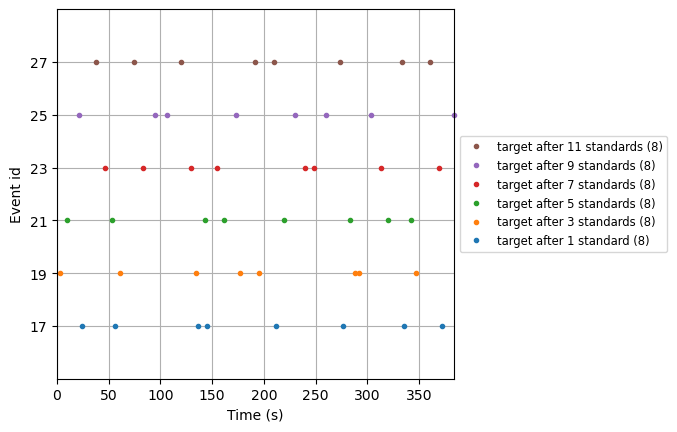

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


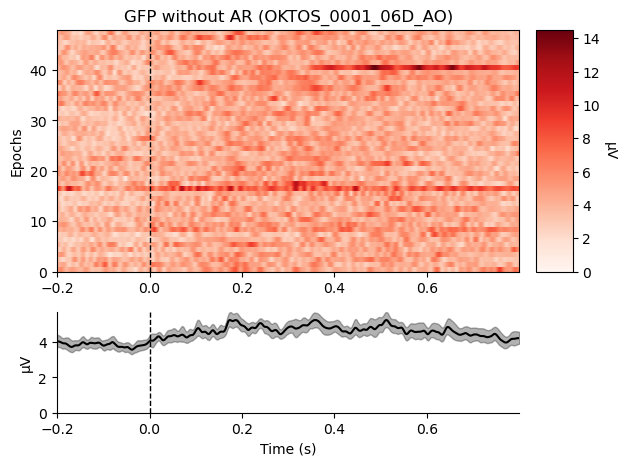

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 7.845816083015955e-05}
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4


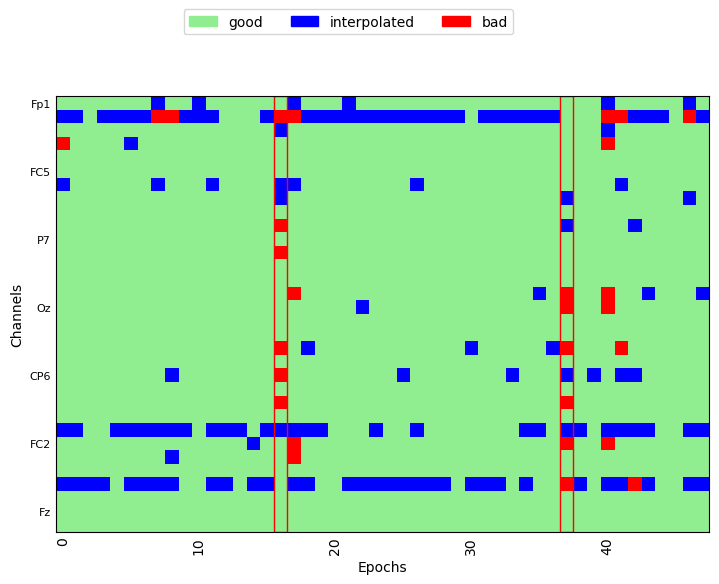

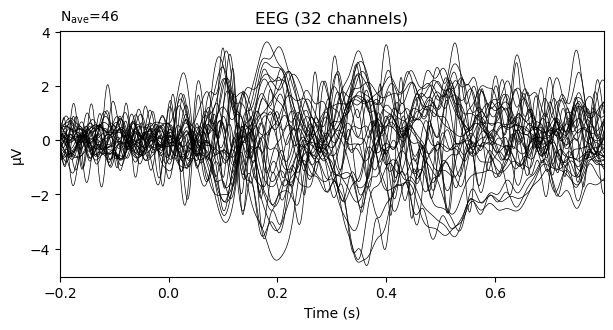

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


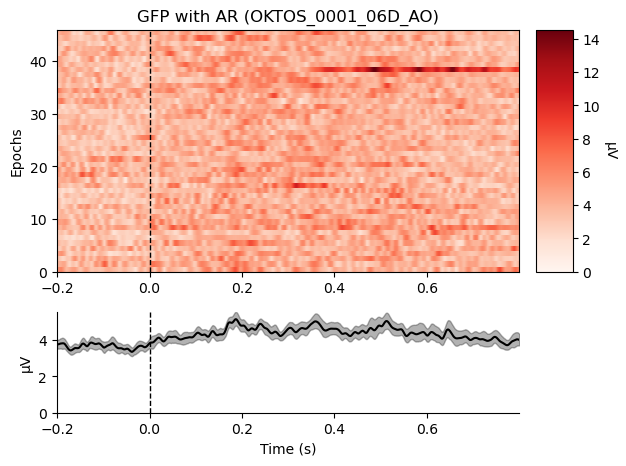

Number of events,46
Events,target after 1 standard: 7target after 11 standards: 8target after 3 standards: 8target after 5 standards: 8target after 7 standards: 8target after 9 standards: 7
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


Overwriting existing file.


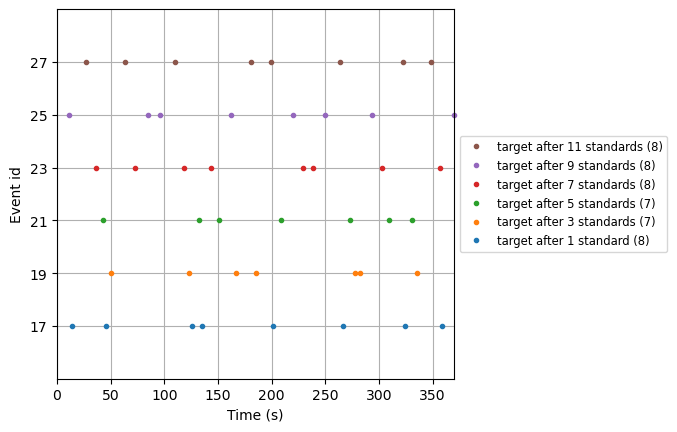

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


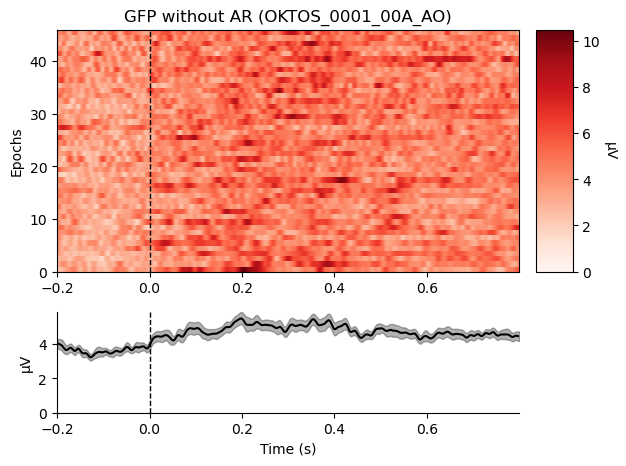

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 5.5453251084599644e-05}
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


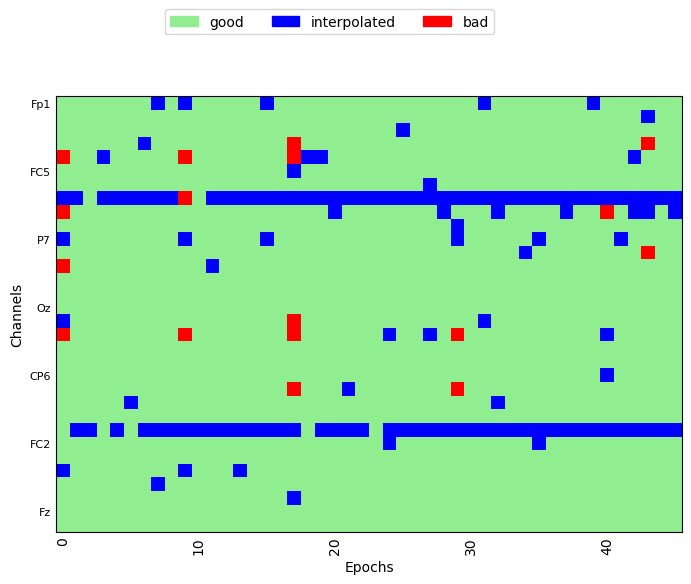

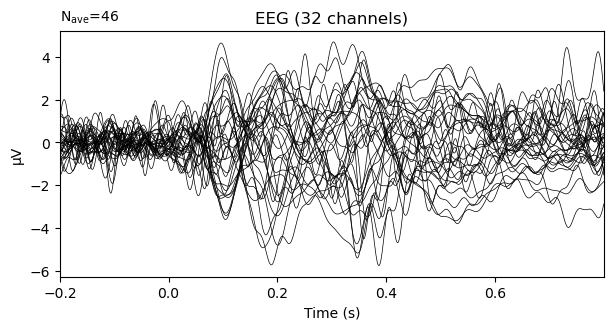

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


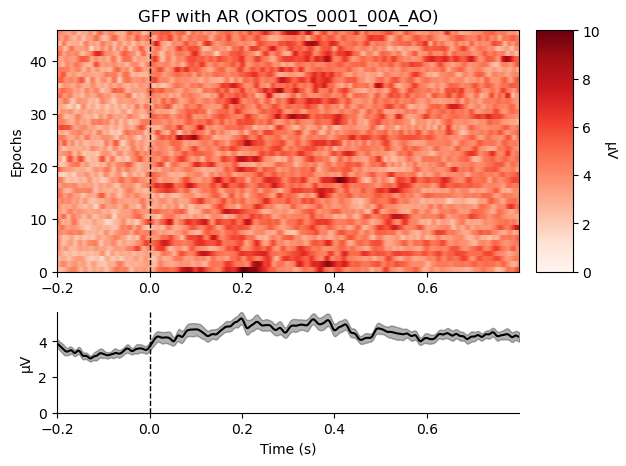

Number of events,46
Events,target after 1 standard: 8target after 11 standards: 8target after 3 standards: 7target after 5 standards: 7target after 7 standards: 8target after 9 standards: 8
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


Overwriting existing file.


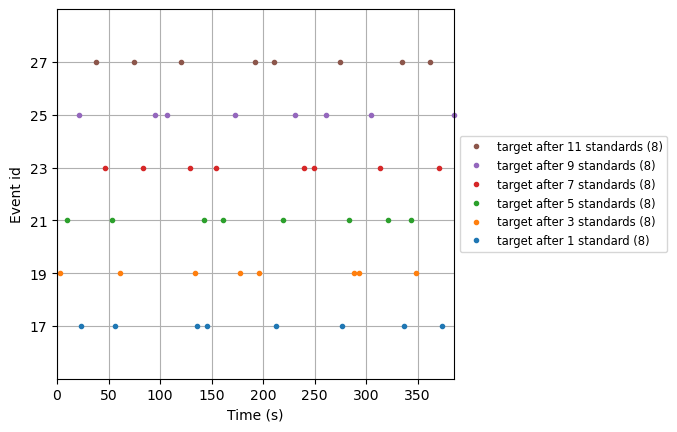

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


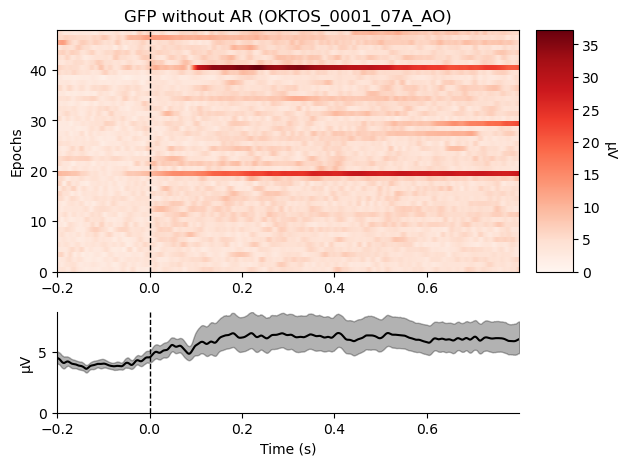

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 8.50740930140716e-05}
Running autoreject on ch_type=eeg




Estimated consensus=1.00 and n_interpolate=31
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


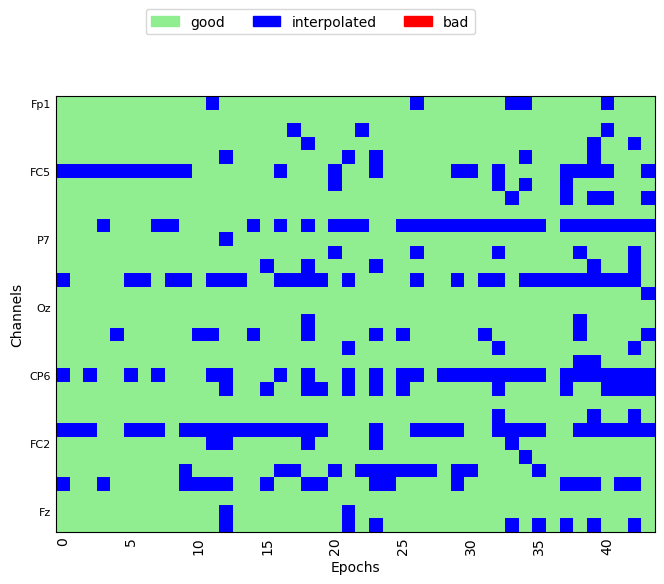

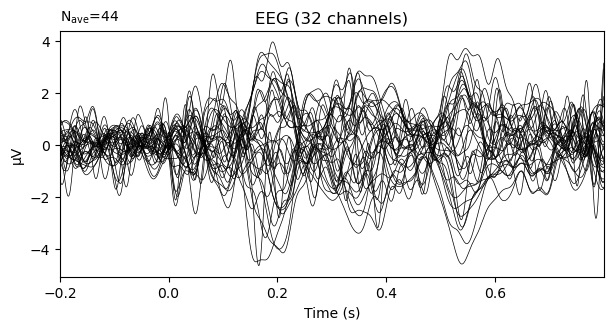

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


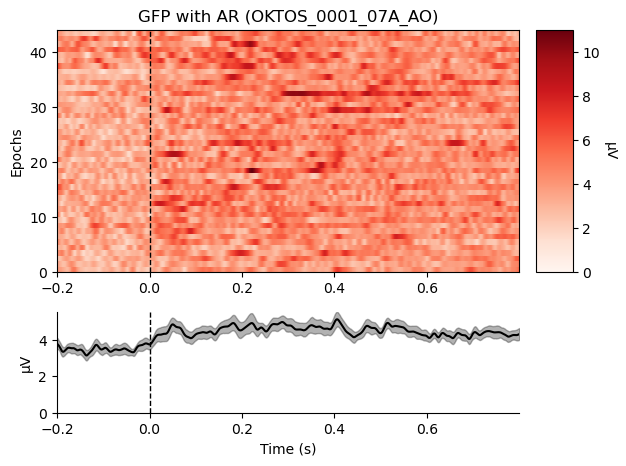

Number of events,44
Events,target after 1 standard: 7target after 11 standards: 7target after 3 standards: 8target after 5 standards: 8target after 7 standards: 6target after 9 standards: 8
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


Overwriting existing file.


In [439]:
tminmax = [-0.2, 0.8]
baseline_correction = (None,0)
event_dict = {'target after 1 standard': 17, 'target after 3 standards': 19,
                'target after 5 standards': 21, 'target after 7 standards': 23,
                'target after 9 standards': 25, 'target after 11 standards': 27}
target_ids = [17, 19, 21, 23, 25, 27]
button_id = 32

for i in range(len(file_dirs)):  
        # Read in the raw EEG data
        raw = mne.io.read_raw_bdf(file_dirs[i],infer_types=True,
                                eog=["EXG1","EXG2","EXG3","EXG4","EXG5","EXG6","EXG7","EXG8"],
                                stim_channel="Status")

        # Set the right montage (Biosemi32) and set reference as average across all channels
        raw = raw.set_montage(mne.channels.make_standard_montage("biosemi32")).load_data()\
                .set_eeg_reference(ref_channels='average')
        
        # Filtering and EOG-removal
        filt = raw.copy().load_data().filter(1,30,verbose=False)
        eog_projs, _ = mne.preprocessing.compute_proj_eog(filt,verbose=False,n_grad=0,n_mag=0,n_eeg=1,reject=None,no_proj=True,ch_name=["EXG1","EXG2","EXG3","EXG4","EXG5","EXG6","EXG7","EXG8"])
        filt.add_proj(eog_projs,remove_existing=True)
        filt.apply_proj()
        filt.drop_channels(["EXG1","EXG2","EXG3","EXG4","EXG5","EXG6","EXG7","EXG8"]) # later remove this from filter funct

        # Find events from the filtered EEG data and name them
        events = mne.find_events(filt,stim_channel='Status',consecutive=False,output='onset')
        buttontarget_events = []

        # Create an array of target tone events which have been responded with a button press (acknowledged deviant tones only)
        for m in range(len(events)):
                for n in target_ids:
                        if events[m][2] == n and events[m+1][2] == button_id:
                                buttontarget_events.append(events[m])
        buttontarget_events = np.asarray(buttontarget_events)

        # Plot all the events
        %matplotlib inline
        fig = mne.viz.plot_events(buttontarget_events, sfreq=filt.info['sfreq'],
                                first_samp=filt.first_samp,event_id=event_dict)
        fig.subplots_adjust(right=0.7)  # make room for legend

        # Create epochs time-locked to target tone events which are followed by button press
        picks = mne.pick_types(filt.info,eeg=True,stim=False)
        epochs = mne.Epochs(filt,buttontarget_events,event_id=event_dict,tmin=tminmax[0],tmax=tminmax[1],
                            baseline=baseline_correction,picks=picks,preload=True)
        
        # Plot the epochs' GFP plot before artefact rejection
        epochs.plot_image(title="GFP without AR ({})".format(subject_names[i]))

        # Use AutoReject to repair and remove epochs which are artefactual
        reject_criteria = get_rejection_threshold(epochs)
        print('Dropping epochs with rejection threshold:',reject_criteria)
        epochs.drop_bad(reject=reject_criteria)

        ar = AutoReject(thresh_method='random_search',random_state=1)
        ar.fit(epochs)
        epochs_ar, reject_log = ar.transform(epochs, return_log=True)

        reject_log.plot('horizontal')

        # Plot the epochs' GFP after artefact rejection
        epochs_ar.average().plot()
        epochs_ar.plot_image(title="GFP with AR ({})".format(subject_names[i]))

        # Display the final epochs object meta-data
        display(epochs_ar)

        # Save the cleaned EEG file as .fif file
        try:
                os.makedirs(export_dir)
        except FileExistsError:
                pass
        try:
                mne.Epochs.save(epochs_ar,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),overwrite=True)
        except FileExistsError:
                pass

Finding peaks for N1, N2, P2, P3 ERP components and plotting them to see if the peaks are in a 'logical' place; in case some of the peaks are not detected or are in a place which is not actually 'a peak', the peaks should be found manually. I would propose that to run all the participants at first and then go over visually the plots and write down participants which had a mis-identified peak (and which ERP it was) and afterwards run these participants again with wider time windows for finding the peaks.

Files in folder: 3


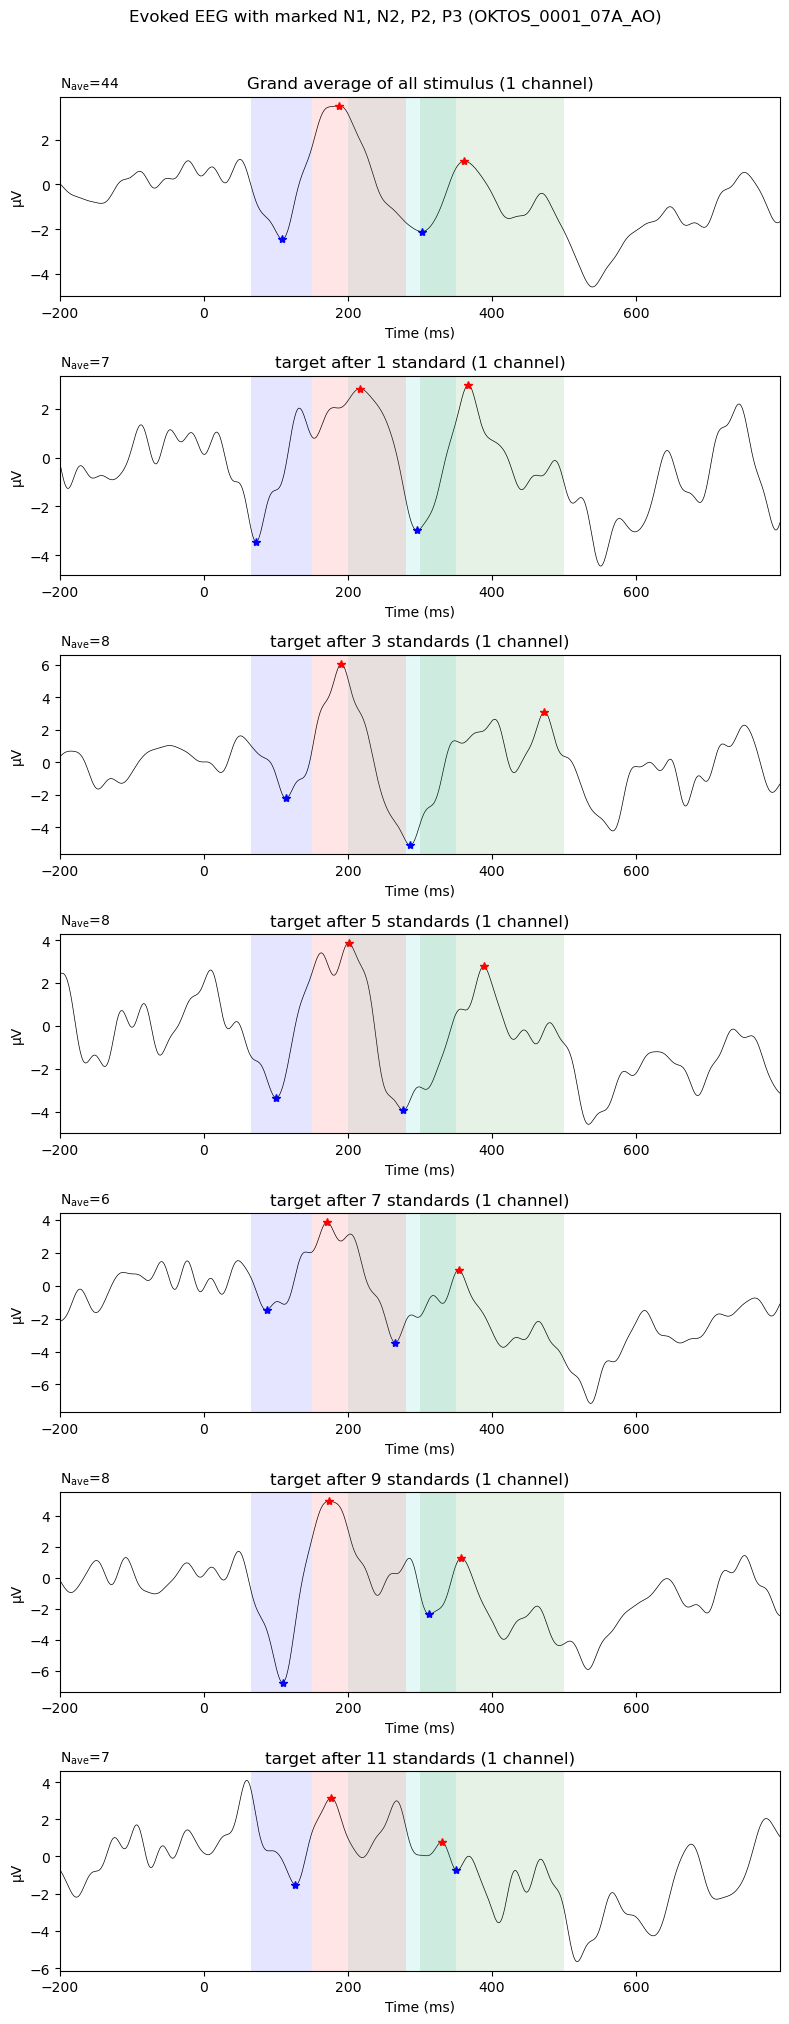

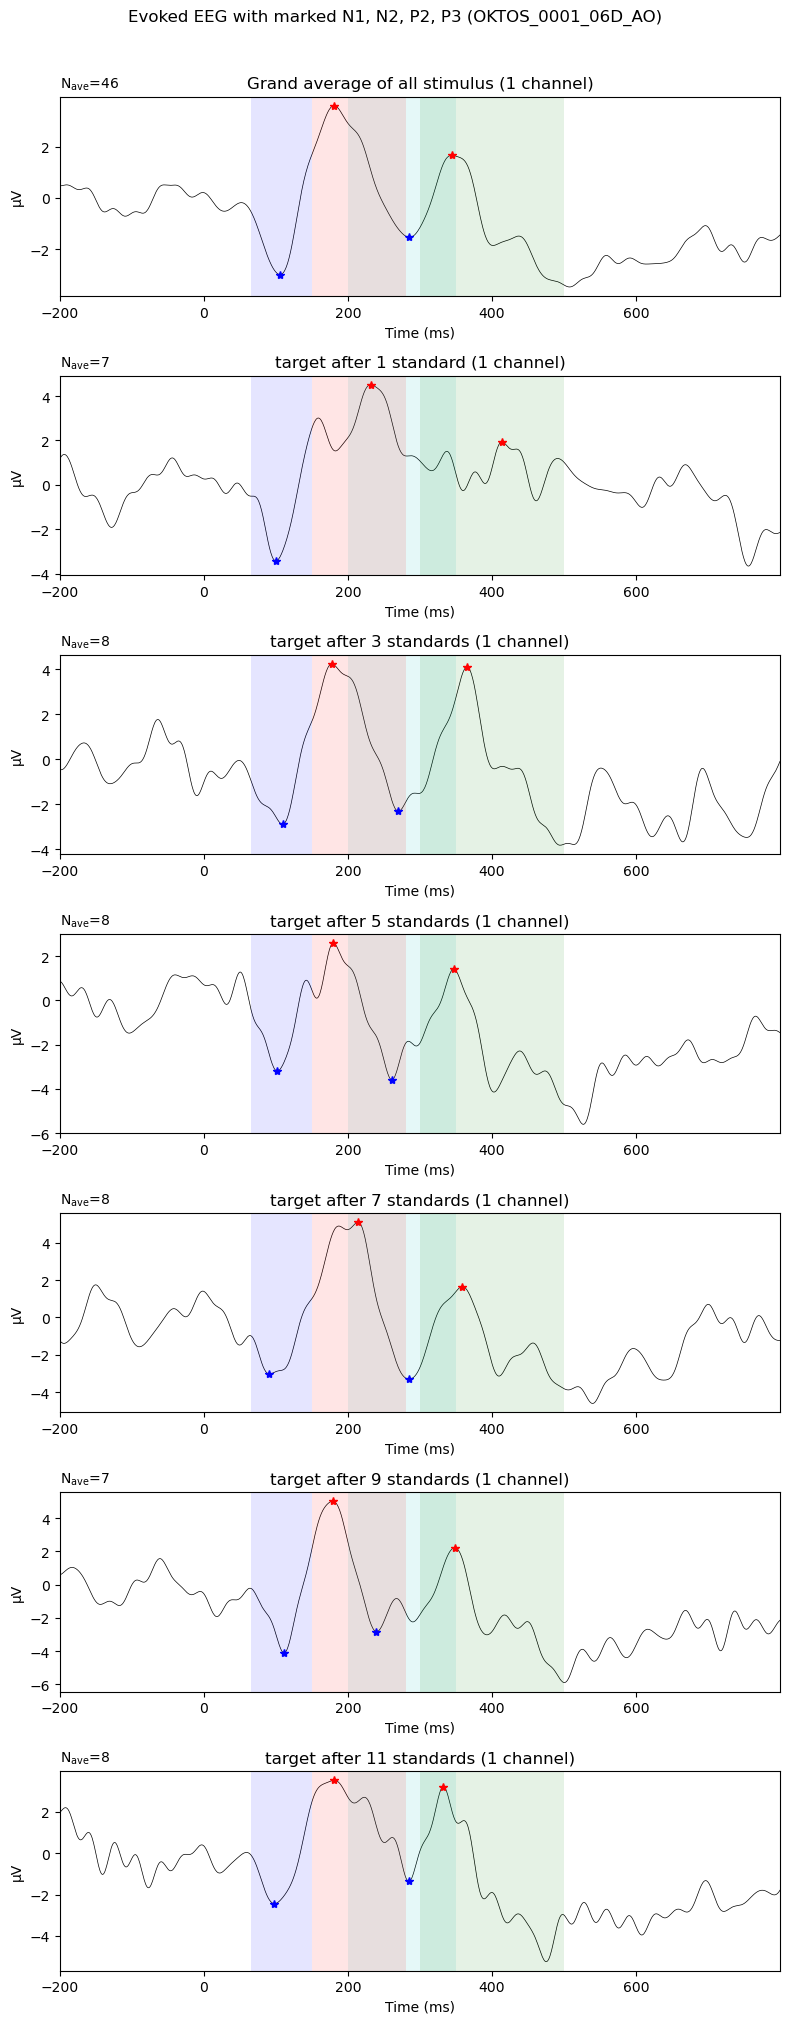

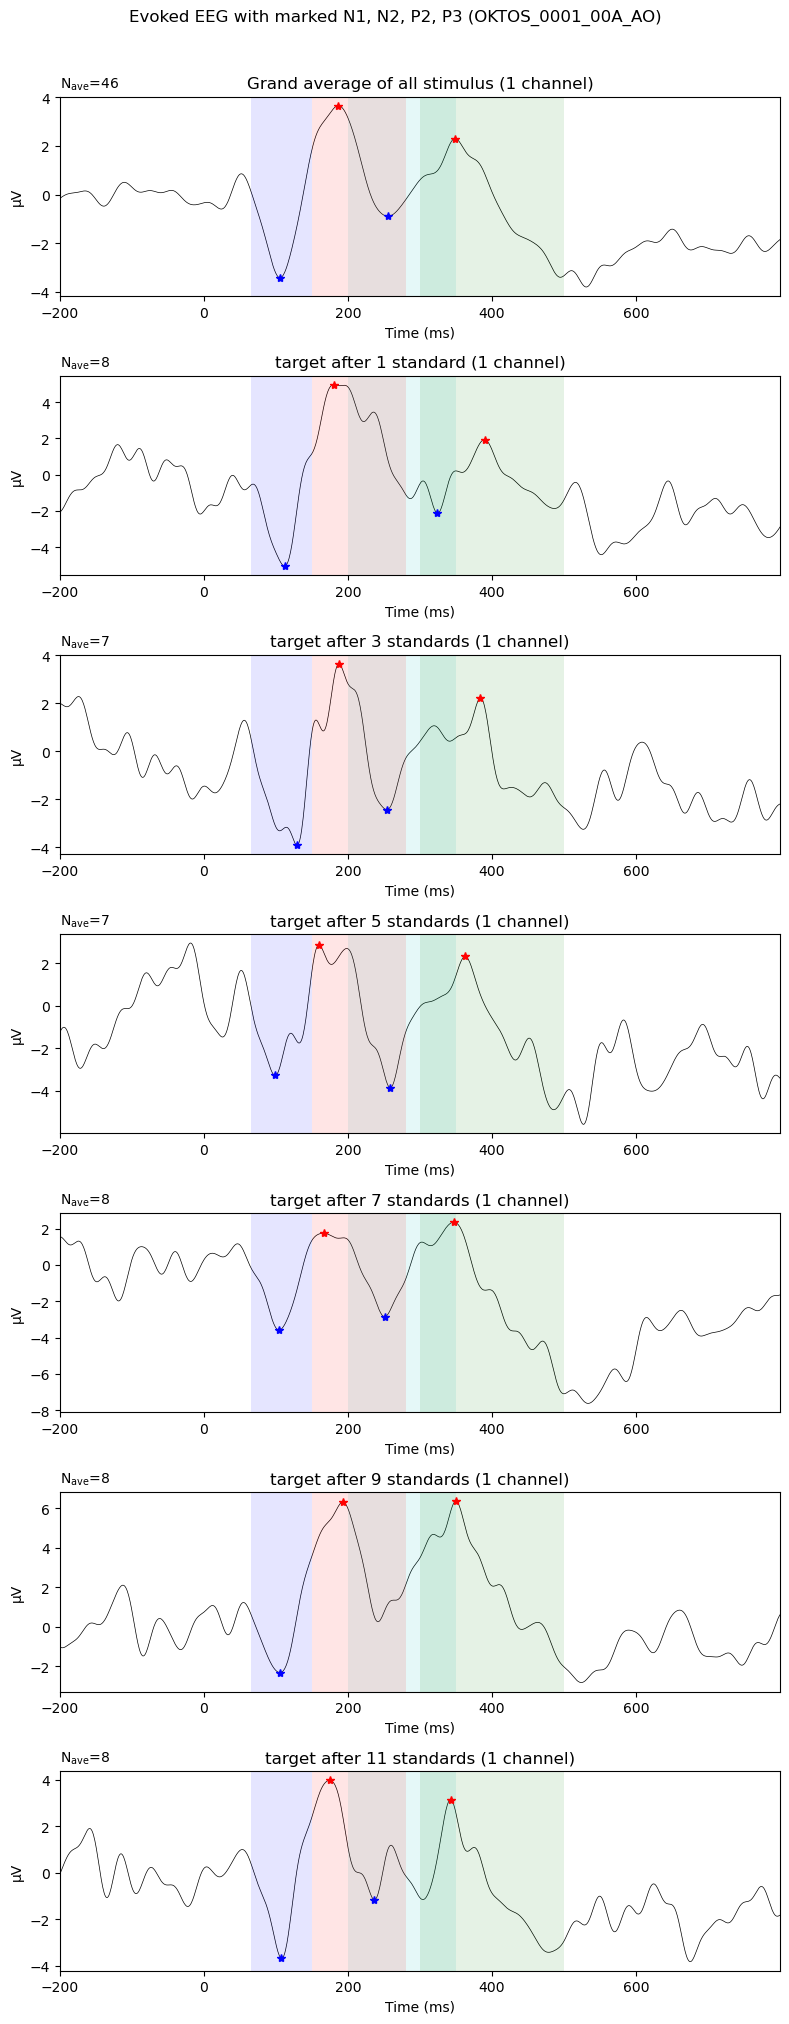

In [440]:
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = read_files(dir_inprogress,"_clean-epo.fif")

# Predefinables
event_list = ['target after 1 standard','target after 3 standards','target after 5 standards',
            'target after 7 standards','target after 9 standards','target after 11 standards']
channel_picks = ['Cz'] ### This is the channel we are looking at, Jim told to look Fz, Cz and Pz
gfp = False
smallunits = True

# Time periods to look for ERPs
erp_time_n1 = [0.065, 0.15]
erp_time_n2 = [0.2, 0.35]
erp_time_p2 = [0.15, 0.28]
erp_time_p3 = [0.3, 0.5]

# Unit conversion
if smallunits == True:
    time_unit='ms'
    time_coef = 1e3
    amplitude_unit='uV'
    amplitude_coef= 1e6
else:
    time_unit='s'
    time_coef = 1
    amplitude_unit='V'
    amplitude_coef = 1

# If more than one channel is looked at, then colorcode the plot
if len(channel_picks) != 1:
    spatial_colors = True
else:
    spatial_colors = False

# Pre-create the variables for evoked objects and arrays to include ERP latencies and amplitudes
evoked_tar_grand = [None]*len(file_dirs)
evoked_tar = [None]*len(file_dirs)
for i in range(len(file_dirs)):
    evoked_tar[i] = [None]*len(event_list)
n1 = np.zeros(shape=(len(file_dirs),len(event_list),2)) # subject, event type, [latency, amplitude]
n2 = np.zeros(shape=(len(file_dirs),len(event_list),2))
p2 = np.zeros(shape=(len(file_dirs),len(event_list),2))
p3 = np.zeros(shape=(len(file_dirs),len(event_list),2))
n1_grand = np.zeros(shape=(len(file_dirs),2))
n2_grand = np.zeros(shape=(len(file_dirs),2))
p2_grand = np.zeros(shape=(len(file_dirs),2))
p3_grand = np.zeros(shape=(len(file_dirs),2))

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)
    
    ### Find ERPs for the grand average evokeds
    evoked_tar_grand[i] = epochs[event_list].average(picks=channel_picks)

    # N100 (fronto-central) -> 65-150ms
    try:
        _, n1_grand[i][0], n1_grand[i][1] = evoked_tar_grand[i].get_peak(ch_type='eeg',tmin=erp_time_n1[0],tmax=erp_time_n1[1],mode='neg',return_amplitude=True)
        n1_grand[i][0] = n1_grand[i][0] * time_coef
        n1_grand[i][1] = n1_grand[i][1] * amplitude_coef
    except:
        n1_grand[i][0],n1_grand[i][1] = nan,nan
    
    # N200 (anterior) -> 200-350ms
    try:
        _, n2_grand[i][0], n2_grand[i][1] = evoked_tar_grand[i].get_peak(ch_type='eeg',tmin=erp_time_n2[0],tmax=erp_time_n2[1],mode='neg',return_amplitude=True)
        n2_grand[i][0] = n2_grand[i][0] * time_coef
        n2_grand[i][1] = n2_grand[i][1] * amplitude_coef
    except:
        n2_grand[i][0], n2_grand[i][1] = nan,nan
    
    # P200 (centro-frontal, parieto-occipital) -> 150-280ms
    try:
        _, p2_grand[i][0], p2_grand[i][1] = evoked_tar_grand[i].get_peak(ch_type='eeg',tmin=erp_time_p2[0],tmax=erp_time_p2[1],mode='pos',return_amplitude=True)
        p2_grand[i][0] = p2_grand[i][0] * time_coef
        p2_grand[i][1] = p2_grand[i][1] * amplitude_coef
    except:
        p2_grand[i][0], p2_grand[i][1] = nan,nan
    
    # P300 (parietal) -> 300-500ms whereas early window is 300-400ms and late is 380-440ms
    try:
        _, p3_grand[i][0], p3_grand[i][1] = evoked_tar_grand[i].get_peak(ch_type='eeg',tmin=erp_time_p3[0],tmax=erp_time_p3[1],mode='pos',return_amplitude=True)
        p3_grand[i][0] = p3_grand[i][0] * time_coef
        p3_grand[i][1] = p3_grand[i][1] * amplitude_coef
    except:
        p3_grand[i][0], p3_grand[i][1] = nan,nan

    ### Find ERPs for the individual events
    for e in range(len(event_list)):
        evoked_tar[i][e] = epochs[event_list[e]].average(picks=channel_picks)

        # N100 (fronto-central) -> 65-150ms
        try:
            _, n1[i][e][0], n1[i][e][1] = evoked_tar[i][e].get_peak(ch_type='eeg',tmin=erp_time_n1[0],tmax=erp_time_n1[1],mode='neg',return_amplitude=True)
            n1[i][e][0] = n1[i][e][0] * time_coef
            n1[i][e][1] = n1[i][e][1] * amplitude_coef
        except:
            n1[i][e][0],n1[i][e][1] = nan,nan
        
        # N200 (anterior) -> 200-350ms
        try:
            _, n2[i][e][0], n2[i][e][1] = evoked_tar[i][e].get_peak(ch_type='eeg',tmin=erp_time_n2[0],tmax=erp_time_n2[1],mode='neg',return_amplitude=True)
            n2[i][e][0] = n2[i][e][0] * time_coef
            n2[i][e][1] = n2[i][e][1] * amplitude_coef
        except:
            n2[i][e][0],n2[i][e][1] = nan,nan
        
        # P200 (centro-frontal, parieto-occipital) -> 150-280ms
        try:
            _, p2[i][e][0], p2[i][e][1] = evoked_tar[i][e].get_peak(ch_type='eeg',tmin=erp_time_p2[0],tmax=erp_time_p2[1],mode='pos',return_amplitude=True)
            p2[i][e][0] = p2[i][e][0] * time_coef
            p2[i][e][1] = p2[i][e][1] * amplitude_coef
        except:
            p2[i][e][0],p2[i][e][1] = nan,nan
        
        # P300 (parietal) -> 300-500ms whereas early window is 300-400ms and late is 380-440ms
        try:
            _, p3[i][e][0], p3[i][e][1] = evoked_tar[i][e].get_peak(ch_type='eeg',tmin=erp_time_p3[0],tmax=erp_time_p3[1],mode='pos',return_amplitude=True)
            p3[i][e][0] = p3[i][e][0] * time_coef
            p3[i][e][1] = p3[i][e][1] * amplitude_coef
        except:
            p3[i][e][0],p3[i][e][1] = nan,nan
        
    # Plot the averaged evoked objects with peaks
    fig, axs = plt.subplots(nrows=len(event_list)+1, ncols=1,figsize=(8, 20), layout='tight')
    plt.suptitle('Evoked EEG with marked N1, N2, P2, P3 ({})'.format(subject_names[i]),y=1.01)
    for ix, ax in enumerate(axs):
        # Grand average of all stimulus
        if ix == 0:
            evoked_tar_grand[i].plot(axes=ax, show=False, time_unit=time_unit, titles='Grand average of all stimulus')
            ax.plot(n1_grand[i][0], n1_grand[i][1], marker='*', color='b')
            ax.axvspan(xmin=erp_time_n1[0]*time_coef,xmax=erp_time_n1[1]*time_coef, facecolor='b', alpha=0.1)
            ax.plot(n2_grand[i][0], n2_grand[i][1], marker='*', color='b')
            ax.axvspan(xmin=erp_time_n2[0]*time_coef,xmax=erp_time_n2[1]*time_coef, facecolor='c', alpha=0.1)
            ax.plot(p2_grand[i][0], p2_grand[i][1], marker='*', color='r')
            ax.axvspan(xmin=erp_time_p2[0]*time_coef,xmax=erp_time_p2[1]*time_coef, facecolor='r', alpha=0.1)
            ax.plot(p3_grand[i][0], p3_grand[i][1], marker='*', color='r')
            ax.axvspan(xmin=erp_time_p3[0]*time_coef,xmax=erp_time_p3[1]*time_coef, facecolor='g', alpha=0.1)
        # Separate stimulus averages
        else:
            title = '{}'.format(event_list[ix-1])
            evoked_tar[i][ix-1].plot(axes=ax, time_unit=time_unit, show=False, titles=title)
            ax.plot(n1[i][ix-1][0], n1[i][ix-1][1], marker='*', color='b')
            ax.axvspan(xmin=erp_time_n1[0]*time_coef,xmax=erp_time_n1[1]*time_coef, facecolor='b', alpha=0.1)
            ax.plot(n2[i][ix-1][0], n2[i][ix-1][1], marker='*', color='b')
            ax.axvspan(xmin=erp_time_n2[0]*time_coef,xmax=erp_time_n2[1]*time_coef, facecolor='c', alpha=0.1)
            ax.plot(p2[i][ix-1][0], p2[i][ix-1][1], marker='*', color='r')
            ax.axvspan(xmin=erp_time_p2[0]*time_coef,xmax=erp_time_p2[1]*time_coef, facecolor='r', alpha=0.1)
            ax.plot(p3[i][ix-1][0], p3[i][ix-1][1], marker='*', color='r')
            ax.axvspan(xmin=erp_time_p3[0]*time_coef,xmax=erp_time_p3[1]*time_coef, facecolor='g', alpha=0.1)
    # print('Grand averages\nN100:',n1_grand[i],'\nN200:',n2_grand[i],'\nP200:',p2_grand[i],'\nP300:',p3_grand[i])
    # print('\nIndividual averages\nN100:',n1[i])
    # print('N200:',n2[i])
    # print('P200:',p2[i])
    # print('P300:',p3[i])

In [441]:
df_erps = pd.DataFrame()
df_erps_grand = pd.DataFrame()
for i in range(len(file_dirs)):
    # Create a dataframe for individual stimulus conditions
    df_erps_temp = pd.DataFrame(np.hstack((n1[i], n2[i], p2[i], p3[i])), columns = ['N1 latency','N1 amplitude',
                                                                                    'N2 latency','N2 amplitude',
                                                                                    'P2 latency','P2 amplitude',
                                                                                    'P3 latency','P3 amplitude'])
    df_erps_temp['Stimulus'] = event_list
    df_erps_temp['Subject'] = subject_names[i]
    df_erps = pd.concat([df_erps, df_erps_temp.set_index('Subject')])
    
    # Create a dataframe for grand average stimulus
    df_erps_grand_temp = pd.DataFrame(np.concatenate((n1_grand[i], n2_grand[i], p2_grand[i], p3_grand[i]))).T
    df_erps_grand_temp['Subject'] = subject_names[i]
    df_erps_grand_temp.columns = ['N1 latency','N1 amplitude','N2 latency','N2 amplitude',
                            'P2 latency','P2 amplitude','P3 latency','P3 amplitude','Subject']
    df_erps_grand = pd.concat([df_erps_grand, df_erps_grand_temp.set_index('Subject')])
display(df_erps_grand)
display(df_erps)

,N1 latency,N1 amplitude,N2 latency,N2 amplitude,P2 latency,P2 amplitude,P3 latency,P3 amplitude
Subject,,,,,,,,
OKTOS_0001_07A_AO,108.398438,-2.445341,302.734375,-2.106226,187.500000,3.510366,361.328125,1.031599
OKTOS_0001_06D_AO,105.468750,-2.994252,285.156250,-1.540958,180.664062,3.601660,343.750000,1.660113
OKTOS_0001_00A_AO,105.468750,-3.420598,254.882812,-0.890975,186.523438,3.653213,348.632812,2.298132


,N1 latency,N1 amplitude,N2 latency,N2 amplitude,P2 latency,P2 amplitude,P3 latency,P3 amplitude,Stimulus
Subject,,,,,,,,,
OKTOS_0001_07A_AO,72.265625,-3.452588,295.898438,-2.992502,216.796875,2.833617,367.187500,2.991903,target after 1 standard
OKTOS_0001_07A_AO,114.257812,-2.221032,286.132812,-5.107970,190.429688,6.061134,472.656250,3.107419,target after 3 standards
OKTOS_0001_07A_AO,100.585938,-3.348830,276.367188,-3.930515,201.171875,3.863397,388.671875,2.773094,target after 5 standards
OKTOS_0001_07A_AO,86.914062,-1.474846,265.625000,-3.459562,170.898438,3.866268,353.515625,0.956846,target after 7 standards
OKTOS_0001_07A_AO,109.375000,-6.774858,312.500000,-2.356600,173.828125,4.946474,357.421875,1.288918,target after 9 standards
OKTOS_0001_07A_AO,126.953125,-1.520906,349.609375,-0.726874,176.757812,3.164986,330.078125,0.785117,target after 11 standards
OKTOS_0001_06D_AO,99.609375,-3.426885,NaN,NaN,231.445312,4.507018,414.062500,1.938914,target after 1 standard
OKTOS_0001_06D_AO,109.375000,-2.895739,269.531250,-2.320153,177.734375,4.241496,365.234375,4.103475,target after 3 standards
OKTOS_0001_06D_AO,101.562500,-3.194011,260.742188,-3.585809,179.687500,2.589858,346.679688,1.410748,target after 5 standards
